# 0D - Supplementary videos for Carbon Panel Plots

Videos capturing the evolution of carbon area densities, sediment thicknesses, subduction slab dip, and spreading rates - all outputs of `Notebook 01-Sources-of-Carbon.ipynb`.

A dependency for the colormaps is the package `cmcrameri`.

In [1]:
import numpy as np
import os
os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"
import gplately.pygplates as pygplates
import gplately
import gplately.tools as tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
import glob, os
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import matplotlib.gridspec as gridspec
from slabdip import SlabDipper
import matplotlib
import pandas as pd

from cmcrameri import cm
import moviepy as mpy

In [2]:
from joblib import Parallel, delayed
import joblib

In [3]:
# Don't change this: directory to input files
output_directory = "../Outputs/Videos/"
os.makedirs(output_directory, exist_ok=True)

grid_directory = "../Grids/InputGrids/"
def defineGridFiles():
    #grid_directory = input_directory+"SRGrids/"
    spreadrate_filename = grid_directory+"SpreadingRate/Cao2024_SPREADING_RATE_grid_{:.2f}Ma.nc"
    agegrid_filename = grid_directory+"SeafloorAge/Cao2024_SEAFLOOR_AGE_grid_{:.2f}Ma.nc"
    return agegrid_filename, spreadrate_filename

In [4]:
# Location of Cao2024 1.8Ga plate model.
model_dir = "./Cao_etal_2024_1.8_Ga_mantle_ref_frame"
# Rotation files (relative to input directory).
rotation_features = [
    model_dir+'/optimisation/1800_1000_rotfile_20240725.rot',
    model_dir+'/optimisation/1000_0_rotfile_20240725.rot',
]

# Topology features (absolute file paths).
# Only include those GPML files that are used for topologies.
topology_features = [
    model_dir+'/1800-1000_plate_boundaries.gpml',
    model_dir+'/250-0_plate_boundaries.gpml',
    model_dir+'/410-250_plate_boundaries.gpml',
    model_dir+'/1000-410-Convergence.gpml',
    model_dir+'/1000-410-Divergence.gpml',
    model_dir+'/1000-410-plate-boundaries.gpml',
    model_dir+'/1000-410-Transforms.gpml',
    model_dir+'/TopologyBuildingBlocks.gpml',
]
# Continent polygon features (absolute file paths).
continent_features = [
    model_dir+'/shapes_continents.gpmlz',
]


model = gplately.PlateReconstruction(rotation_model=rotation_features, topology_features=topology_features)

# For this notebook, we only need to define a set of passive margins as COBs.
COBs = model_dir+"/COBfile_1800_0.gpml"
continents = model_dir+"/shapes_continents.gpmlz"
coastlines = model_dir+'/shapes_coasts.gpmlz'
gplot = gplately.PlotTopologies(model, continents=continents, COBs=COBs, coastlines=coastlines)

max_time = 1800
min_time = 0
reconstruction_times = np.arange(max_time, min_time-1, -1)

### A function to plot all plate polygon boundaries

In [5]:
def latlonticks(ax):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False,
              linewidth=1, color='gray', alpha=0.3,)

    ax.text(0.49,-0.03, '60°E', transform=ax.transAxes)
    ax.text(0.46,-0.03, '0°', transform=ax.transAxes)
    ax.text(0.40,-0.025, '60°W', transform=ax.transAxes)
    
    gl.top_labels=False
    gl.bottom_labels=False
    return

## Plots of sedimentary carbon storage 
for 150, 100, 50 and 0 Ma (2 x 2 map panel) ) (use colormap lipori)

In [7]:
def plot_sed_carbon(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    grd = gplately.Raster(

        "../Grids/Reservoirs/Sediment/mean/carbon_sediment_grid_{:04d}.nc".format(time)
    ).data + 0.000001 # slightly offset all values from 0 to ensure they aren't cropped by lognorm

    lognorm_cmap = cm.batlow
    
    # Sample the colormap to create an array of colors
    colors = lognorm_cmap(np.linspace(0, 1, 256))

    lognorm_cmap.set_under(colors[0])
    lognorm_cmap.set_bad('lightgrey')

    # times by 1e6 to go from Mt to t
    im = ax.imshow(
        grd*1e6, origin='lower', cmap=lognorm_cmap,
        norm=mcolors.LogNorm(vmin=1e0, vmax=1e2),
        transform=ccrs.PlateCarree(), interpolation='nearest'
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_continents(ax, facecolor='lightgrey', edgecolor=None)
    gplot.plot_coastlines(ax, facecolor='silver', edgecolor=None)
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, color='k', zorder=8)
    
    latlonticks(ax)

    plt.subplots_adjust(wspace=0.02)
    cb_ax = fig.add_axes([0.4, 0.02, 0.25, 0.02])
    cb = fig.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.8, pad=0.1, extend='max')
    cb.set_label(label='Carbon area density (T/m^$2$)')

    if save_fig:
        os.makedirs(output_directory+"carb_sed", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"carb_sed/sediment_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
        )
    else:
        plt.show()
        
    plt.close()
    return

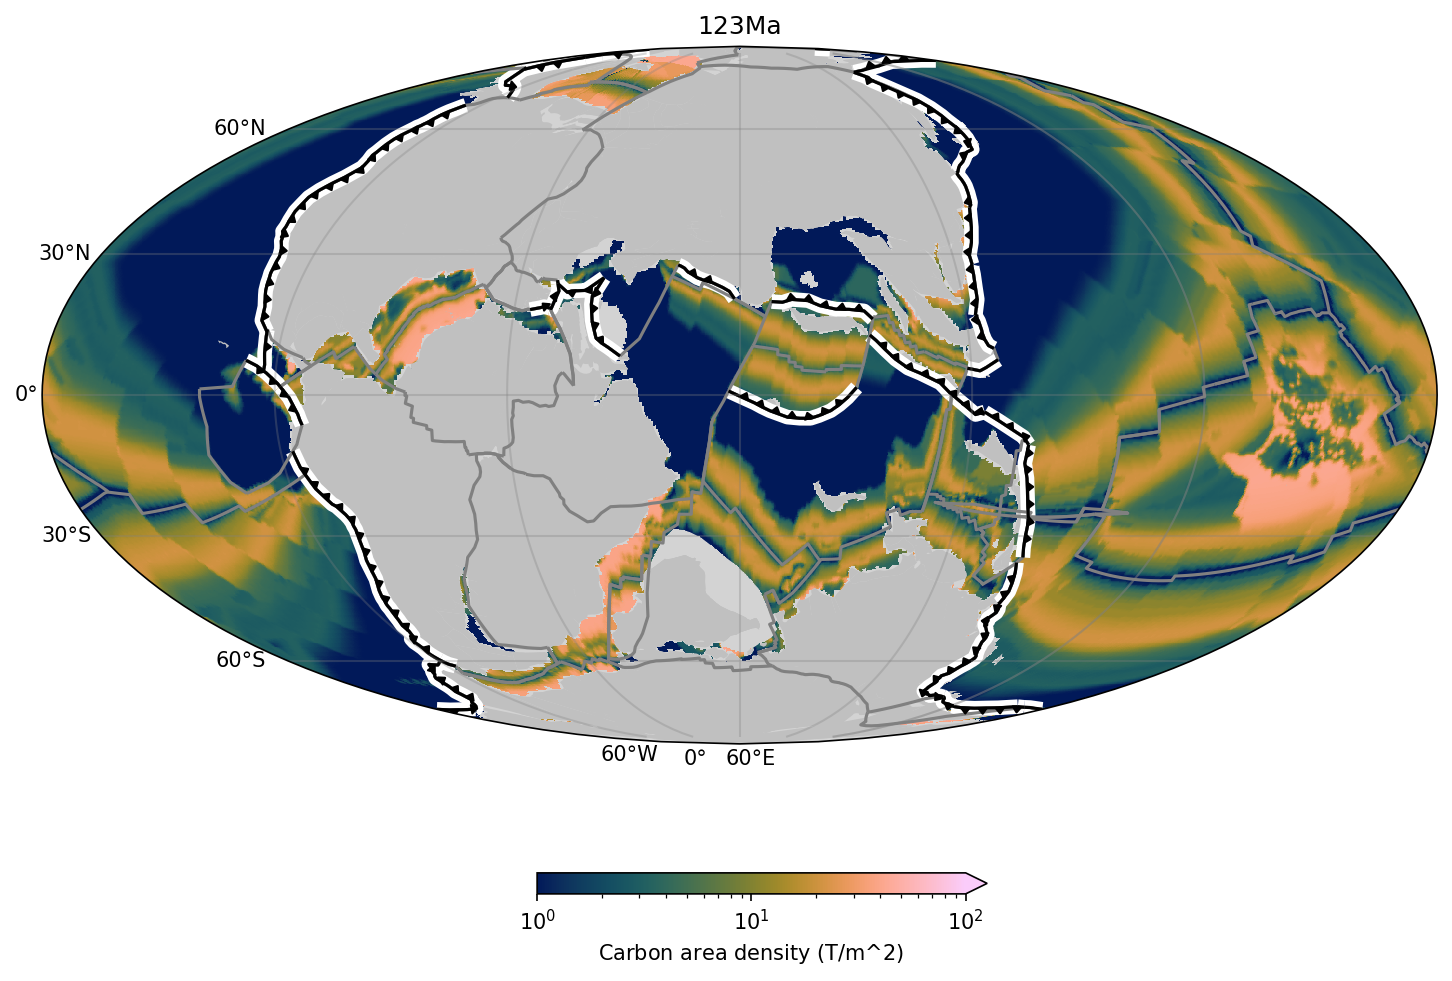

In [8]:
plot_sed_carbon(time=123)

In [9]:
carbsed_time = np.arange(170,-1,-1)
# Use LokyBackend to protect the netCDF routine
carbsed = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_sed_carbon) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in carbsed_time)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:  3.1min finished


In [10]:
import moviepy.editor as mpy

frame_list = []
for time in carbsed_time:
    frame_list.append(
        output_directory+"/carb_sed/sediment_carbon_mean_area_density_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(output_directory+"/sediment_carbon_mean_area_density.mp4", fps=24)


Moviepy - Building video ../Outputs/Muller22_Sep17/Videos//sediment_carbon_mean_area_density.mp4.
Moviepy - Writing video ../Outputs/Muller22_Sep17/Videos//sediment_carbon_mean_area_density.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Sep17/Videos//sediment_carbon_mean_area_density.mp4


## Plots of serpentinite carbon storage 

at 1000, 800, 700, 600, 500, 400, 300, 200, 100, 0 Ma (2 x 5 map panel) (use colormap navia)

In [17]:
def plot_serpentinite(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    grd = gplately.Raster(
        "../Grids/Reservoirs/Serpentinite/mean/carbon_serpentinite_grid_{:04d}.nc".format(time)
    ).data

    ax.set_facecolor('lightgrey')
    
    im = ax.imshow(
        grd*1e6, origin='lower', cmap=cm.imola, 
        transform=ccrs.PlateCarree(), interpolation='nearest',
        vmax=3,
        vmin=0
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_continents(ax, facecolor='lightgrey', edgecolor='lightgrey')
    gplot.plot_coastlines(ax, facecolor='silver', edgecolor='silver' )
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, color='k', label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, color='k', zorder=8)
     
    latlonticks(ax)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Carbon area density (T/m^$2$)', extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/serpentinite", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/serpentinite/serpentinite_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
        )
    else:
        plt.show()
    plt.close()
    return

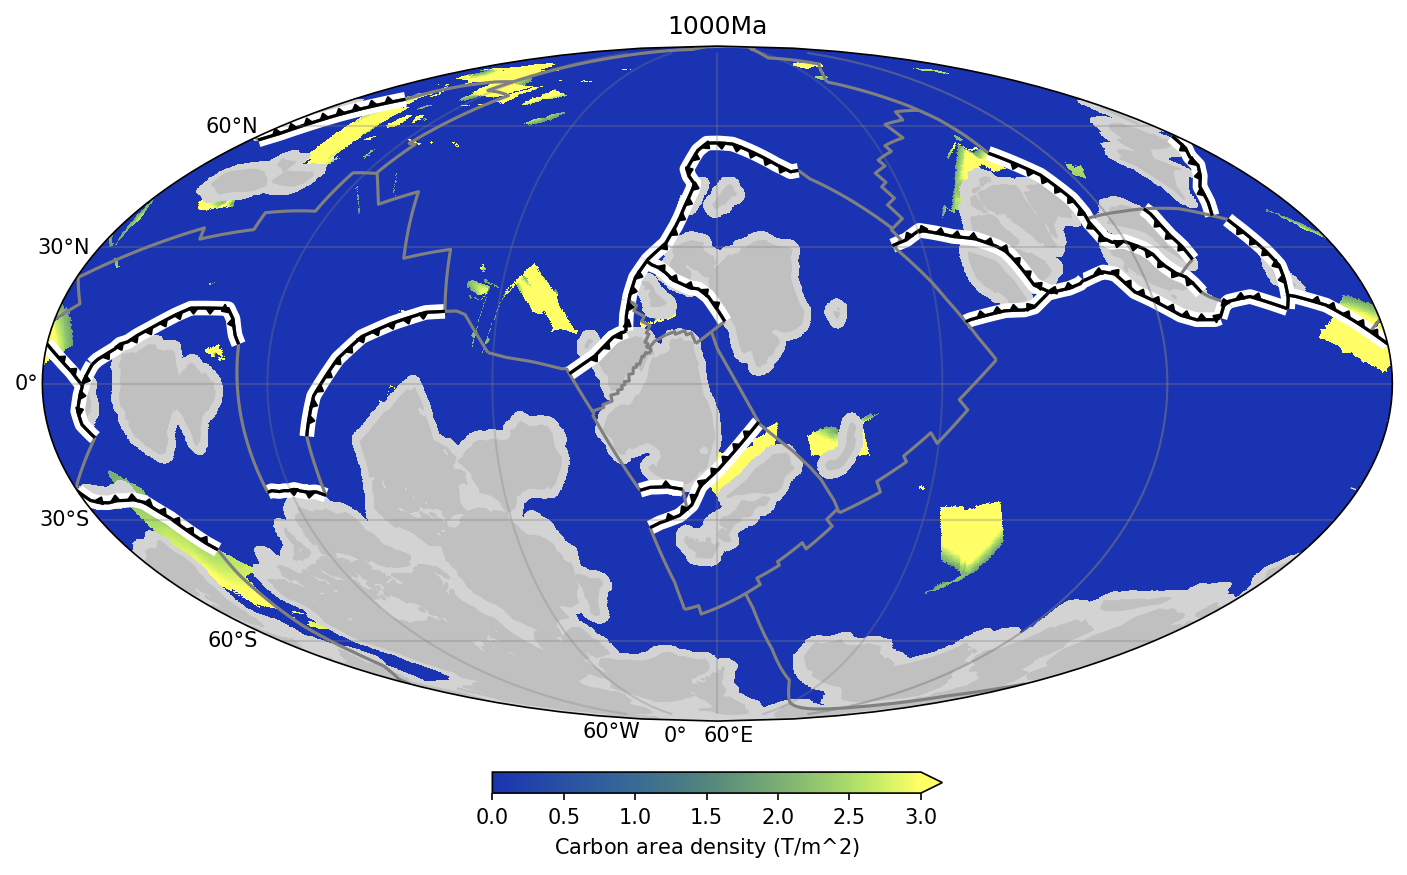

In [18]:
plot_serpentinite(time=1000)

In [19]:
# Use LokyBackend to protect the netCDF routine
serpentinite = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_serpentinite) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 14.0min
/Users/laurenilano/opt/miniconda3/envs/gplately2025/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 25.8min
/Users/laurenilano/opt/miniconda3/envs/gplately2025/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed: 37.8min finished


In [48]:
frame_list = []

for time in reconstruction_times:
    frame_list.append(
        output_directory+"/serpentinite/serpentinite_carbon_mean_area_density_{}Ma.png".format(time)
    )

#clip = mpy.ImageSequenceClip(frame_list, fps=25)
#clip.write_videofile(output_directory+"/serpentinite_carbon_mean_area_density.mp4", fps=24)

clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/serpentinite_carbon_mean_area_density.mp4",
    fps=25,
    codec="libx264",
    bitrate="5000k",
    audio=False,
    logger=None,
    ffmpeg_params=[
        "-vf",
        "pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-pix_fmt",
        "yuv420p",
    ],
)

## Crustal carbon storage 
at 1000, 800, 700, 600, 500, 400, 300, 200, 100, 0 Ma (2 x 5 map panel) (use colormap batlow)


In [21]:
def plot_crustal(time, save_fig=False):
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr
    ax.set_facecolor('lightgrey')

    grd = gplately.Raster(

        "../Grids/Reservoirs/Crust/mean/carbon_crust_grid_{:04d}.nc".format(time)
    ).data

    
    im = ax.imshow(
        grd*1e6, origin='lower', cmap=cm.batlow,
        transform=ccrs.PlateCarree(), interpolation='nearest',
        vmin=3,
        vmax=10
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_continents(ax, facecolor='lightgrey', edgecolor='lightgrey' )
    gplot.plot_coastlines(ax, facecolor='silver', edgecolor='silver' )
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, zorder=9)

     
    latlonticks(ax)


    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Carbon area density (T/m^$2$)', extend='both')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/crust", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/crust/crust_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
        
    plt.close()
    return
    

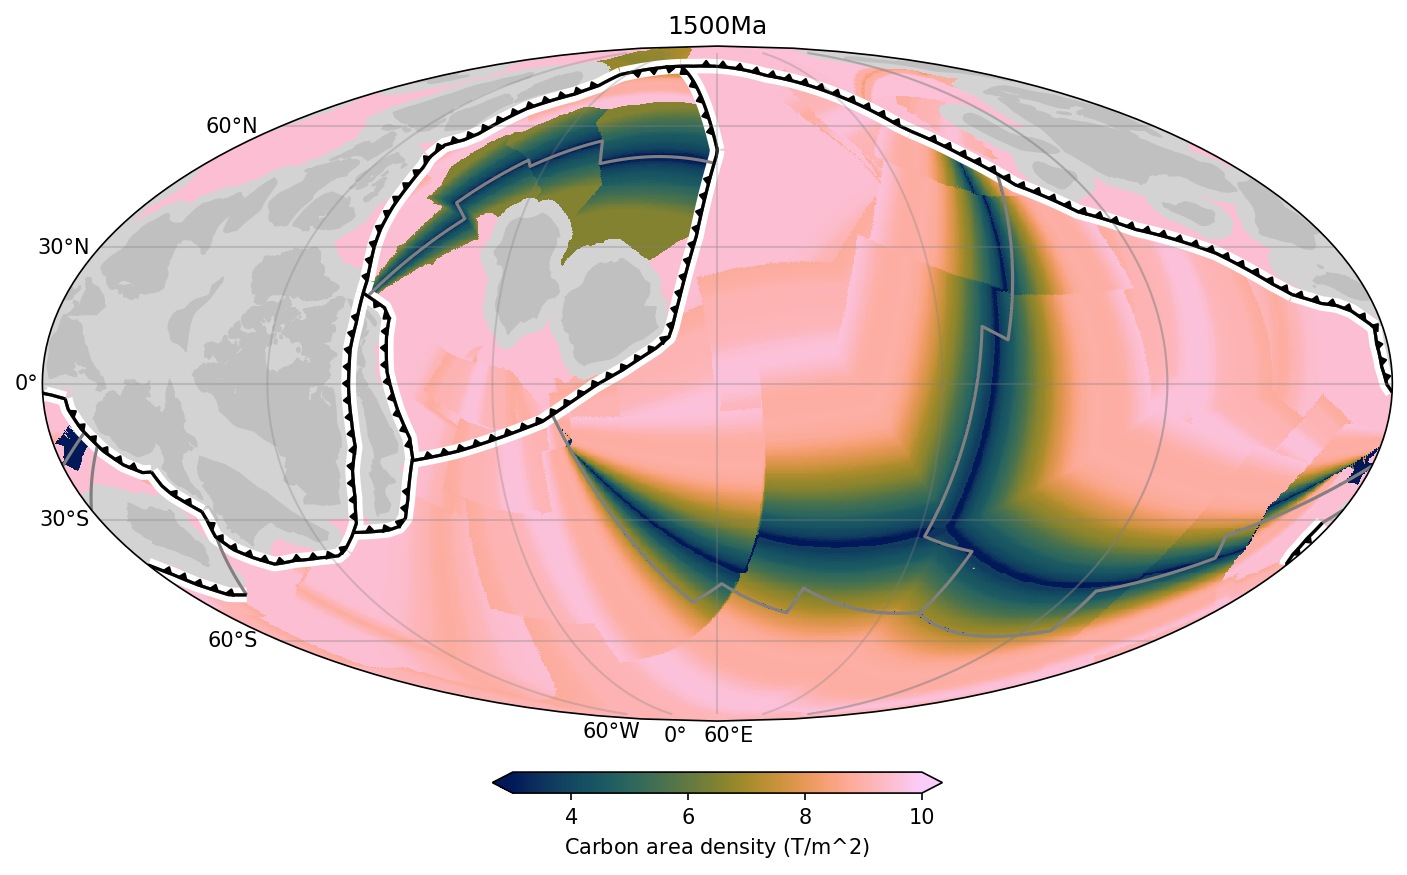

In [22]:
plot_crustal(time=1500)

In [23]:
# Use LokyBackend to protect the netCDF routine
crustal = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_crustal) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 26.1min
/Users/laurenilano/opt/miniconda3/envs/gplately2025/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed: 38.3min finished


In [47]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/crust/crust_carbon_mean_area_density_{}Ma.png".format(time)
    )


clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/crust_carbon_mean_area_density.mp4",
    fps=25,
    codec="libx264",
    bitrate="5000k",
    audio=False,
    logger=None,
    ffmpeg_params=[
        "-vf",
        "pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-pix_fmt",
        "yuv420p",
    ],
)


# Crustal carbon with carbon outflux

Carbon outgassing flux along mid-ocean ridges - methodology taken from Notebook 3: 

CO2 outflux is related to the following parameters:

- $u$ Spreading rate [cm/yr]
- $d$ Compaction length (fixed?) [log10 km]
- $T$ Temperature of the mantle [deg C]
- $c$ Fertility of the mantle [wt %]
- $v$ CO2 volatile content (elevated near hotspots) [wt ppm]

These are fitted from a series of polynomial functions.

__Ridge outflux fit:__

$$
F = A + B_u (u - u_{\mathrm{ref}}) + B_d (d - d_{\mathrm{ref}}) + B_T (T - T_{\mathrm{ref}}) + B_c (c - c_{\mathrm{ref}}) + B_v (v - v_{\mathrm{ref}})
$$

> __Citations:__
> * Keller, T., Katz, R. F., & Hirschmann, M. M. (2017). Volatiles beneath mid-ocean ridges: Deep melting, channelised transport, focusing, and metasomatism. Earth and Planetary Science Letters, 464, 55–68. https://doi.org/10.1016/j.epsl.2017.02.006
> * Le Voyer, M., Kelley, K. A., Cottrell, E. & Hauri, E. H. (2017) Heterogeneity in mantle carbon content from CO2-undersaturated basalts. Nat Commun 8: 14062.

In [6]:
# Define the ridge outflux polynomial
u_ref = 3.0
d_ref = 1.504  # 1 - 2
T_ref = 1350.0 # 1300. - 1400.
c_ref = 19.0   # 15 - 25
v_ref = 100.0 # ±54 ppm CO2 (Le Voyer et al. (2017))
delta_v_ref = 20.0

def ridge_outflux(u, d, T, c, v):
    u = np.abs(u)
    A = 0.9919
    B_u = 0.3162
    B_d = -0.3739
    B_T = 0.0089
    B_c = 0.0294
    B_v = 0.0095
    return A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref)

In [27]:
def plot_MOR_outgassing(time, save_fig=False):
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    grd = gplately.Raster(

        "../Grids/Reservoirs/Crust/mean/carbon_crust_grid_{:04d}.nc".format(time)
    ).data

    cmap = cm.batlow
    cmap.set_bad('lightgrey')

    im = ax.imshow(
        grd*1e6, origin='lower', cmap=cmap,
        transform=ccrs.PlateCarree(), interpolation='nearest',
        vmin=3,
        vmax=10
    )
    ax.set_title("{} Ma".format(time))
    extent_globe = [-180,180,-90,90]
    
    gplot.time = time
    gplot.plot_coastlines(ax, facecolor='silver', edgecolor='silver' )
    gplot.plot_trenches(ax, color='w', linewidth=4)

    latlonticks(ax)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.1, 0.21, 0.25, 0.02])
    cb = fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Carbon area density (T/m$^2$)', extend='both')
    cb.set_label(label='Carbon area density (T/m$^2$)')


    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    

    # ---------- CALCULATE MOR OUTGASSING
    ridge_data = model.tessellate_mid_ocean_ridges(
        gplot.time,
        tessellation_threshold_radians = np.radians(0.01),
        anchor_plate_id=0
    )
    
    ridge_lon = ridge_data[:,0]
    ridge_lat = ridge_data[:,1]
    ridge_vel = ridge_data[:,2]
    ridge_len = np.radians(ridge_data[:,3]) * 1e3 * pygplates.Earth.mean_radius_in_kms

    # Set 3 dimensions tentatively in case min and max are needed in future
    CO2_outflux = np.empty((3, len(ridge_vel)))
    CO2_influx = np.empty((3, len(ridge_vel)))
    
    # Half spreading rate - set "1" for mean
    v_mean = v_ref
    CO2_outflux[1] = ridge_outflux(0.5*ridge_vel, d_ref, T_ref, c_ref, v_mean) # t/m/yr  mean

    sc = ax.scatter(ridge_lon, ridge_lat, c=CO2_outflux[1], cmap='autumn', vmin=0, vmax=2,

        transform=ccrs.PlateCarree(), rasterized=True,
    )

    if time == 500. or time == 700.:
        gplot.plot_all_topological_sections(ax, color='dimgrey', tessellate_degrees=1)
    else:
        gplot.plot_all_topological_sections(ax, color='darkgrey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, zorder=8)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])

    cax2 = fig.add_axes([0.5, 0.21, 0.25, 0.02])
    cb2 = fig.colorbar(sc, cax=cax2, orientation='horizontal', label='Mid-ocean ridge carbon outflux MtC/yr', extend='max')
    cb2.set_label(label='Mid-ocean ridge carbon outflux MtC/yr')
    
    ax.set_global()
    
    if save_fig:
        os.makedirs(output_directory+"/MOR_outgassing", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/MOR_outgassing/MOR_outgassing_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
            )
    else:
        plt.show()

    plt.close()
    return

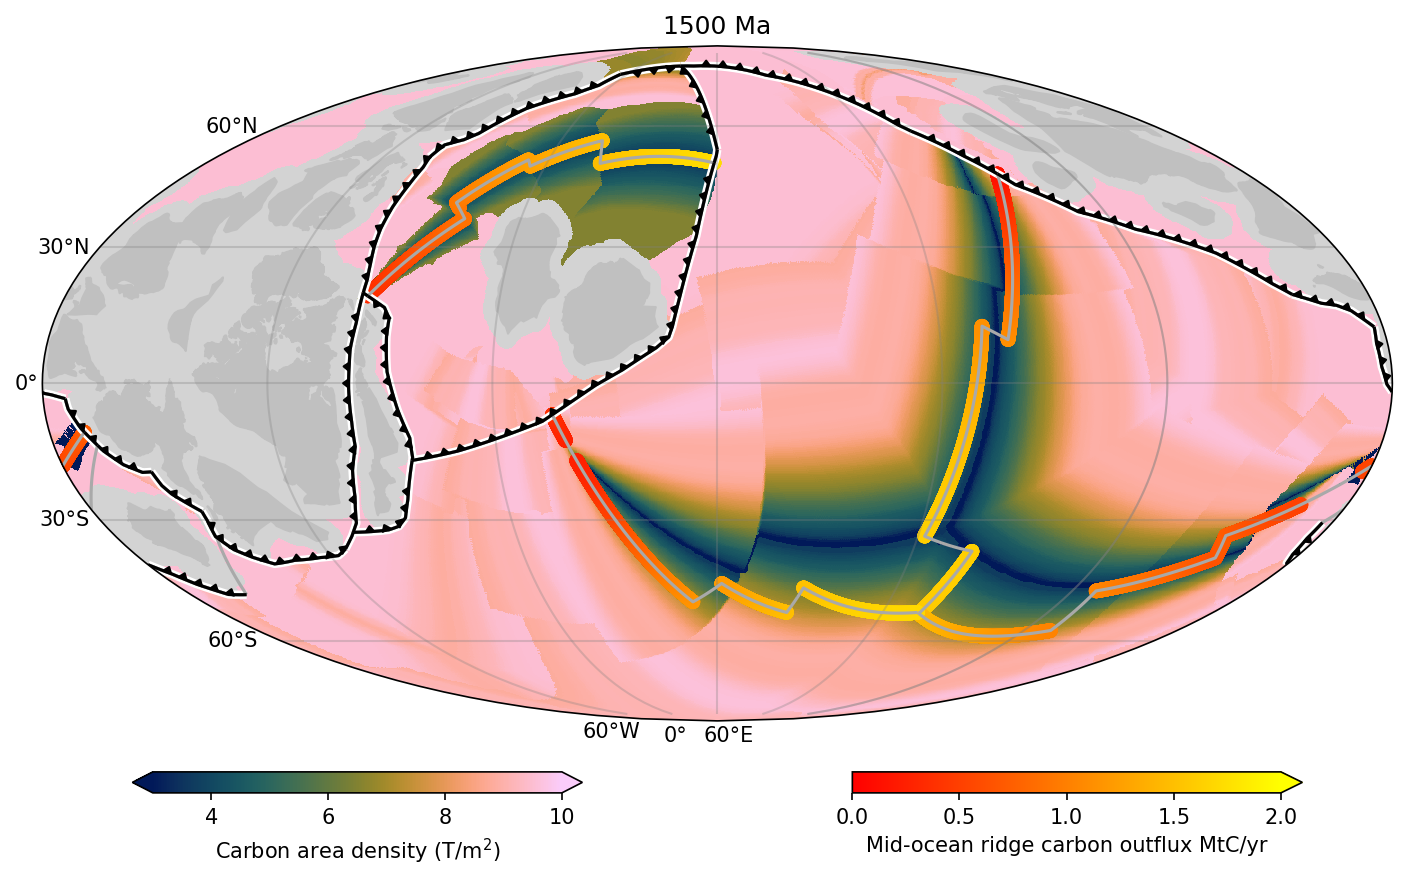

In [28]:
plot_MOR_outgassing(time=1500)

In [29]:
# Use LokyBackend to protect the netCDF routine
lithosphere = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_MOR_outgassing) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 56.0min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 100.6min
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed: 157.8min
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed: 227.3min
[Parallel(n_jobs=-1)]: Done 1801 out of 1801 | elapsed: 229.9min finished


In [31]:
import moviepy.editor as mpy

frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/MOR_outgassing/MOR_outgassing_{}Ma.png".format(time)
    )

#clip = mpy.ImageSequenceClip(frame_list, fps=25)
#clip.write_videofile(
#    output_directory+"/lithosphere_carbon_mean_area_density.mp4",
#    fps=24
#)

clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/MOR_outgassing.mp4",
    fps=25,
    codec="libx264",
    bitrate="5000k",
    audio=False,
    logger=None,
    ffmpeg_params=[
        "-vf",
        "pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-pix_fmt",
        "yuv420p",
    ],
)

## Lithospheric carbon storage 
at 1000, 800, 700, 600, 500, 400, 300, 200, 100, 0 Ma (2 x 5 map panel) (use colormap lapaz)


In [25]:
def plot_lithosphere(time, save_fig=False):
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    grd = gplately.Raster(
        "../Grids/Reservoirs/Lithosphere/mean/carbon_lithosphere_grid_{:04d}.nc".format(time)
    ).data

    ax.set_facecolor('lightgrey')
    
    im = ax.imshow(
        grd*1e6, origin='lower', cmap=cm.lapaz, 
        transform=ccrs.PlateCarree(), interpolation='nearest',
        vmin=3.6, vmax = 4.6
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_continents(ax, facecolor='lightgrey', edgecolor='lightgrey', )
    gplot.plot_coastlines(ax, facecolor='silver',edgecolor='silver', alpha=0.46, )
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, zorder=2)

     
    latlonticks(ax)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Carbon area density (T/m^$2$)', extend='both')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/lithosphere", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/lithosphere/lithosphere_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
            )
    else:
        plt.show()

    plt.close()
    return

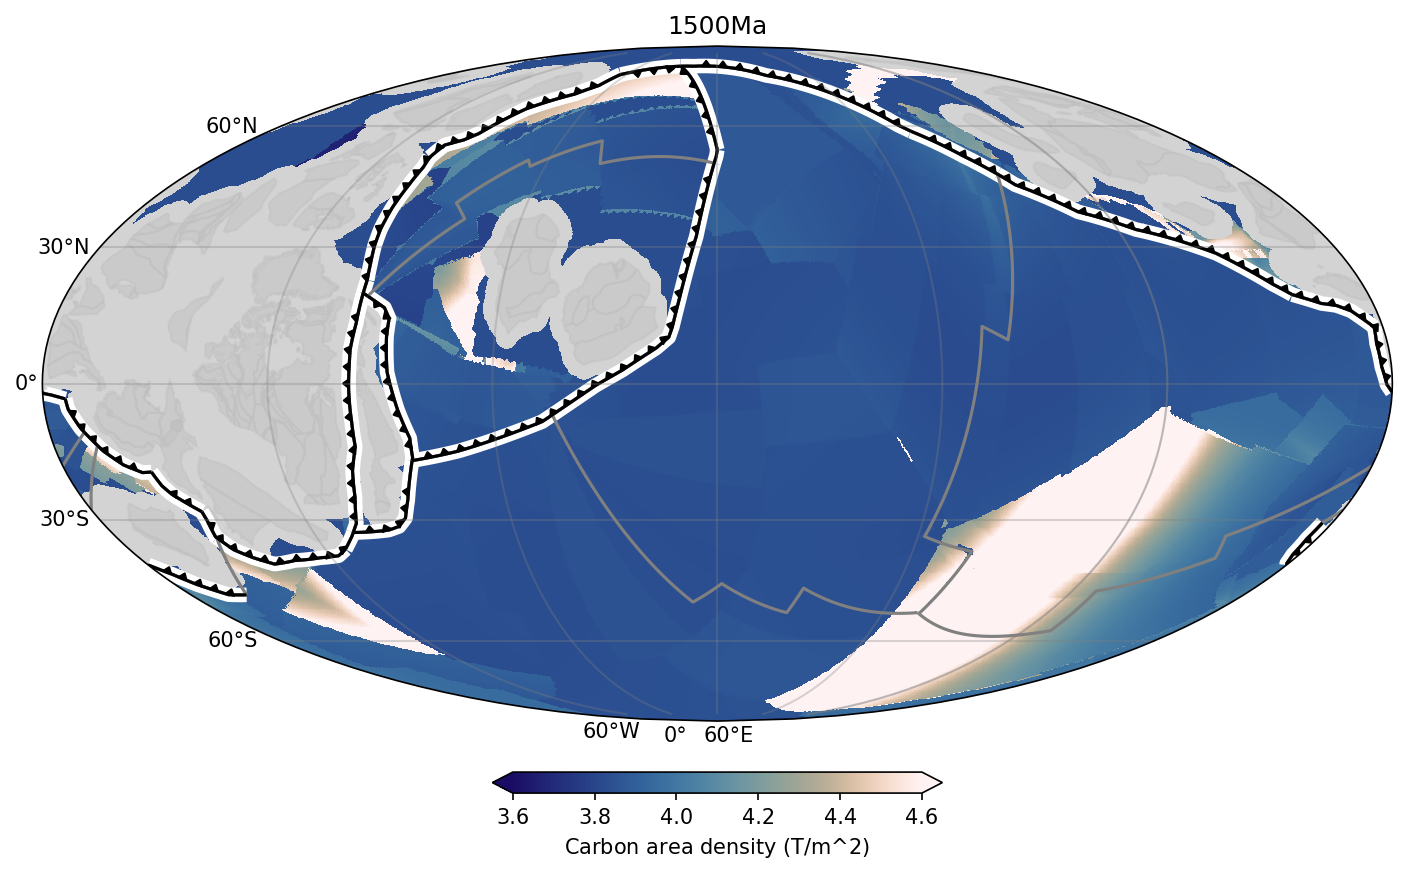

In [26]:
plot_lithosphere(time=1500)

In [27]:
# Use LokyBackend to protect the netCDF routine
lithosphere = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_lithosphere) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 28.3min
/Users/laurenilano/opt/miniconda3/envs/gplately2025/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed: 40.6min finished


In [46]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/lithosphere/lithosphere_carbon_mean_area_density_{}Ma.png".format(time)
    )

#clip = mpy.ImageSequenceClip(frame_list, fps=25)
#clip.write_videofile(
#    output_directory+"/lithosphere_carbon_mean_area_density.mp4",
#    fps=24
#)

clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/lithosphere_carbon_mean_area_density.mp4",
    fps=25,
    codec="libx264",
    bitrate="5000k",
    audio=False,
    logger=None,
    ffmpeg_params=[
        "-vf",
        "pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-pix_fmt",
        "yuv420p",
    ],
)

## Plots of slab dip (degrees)

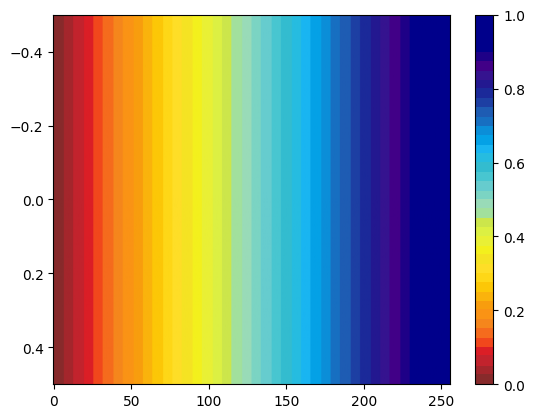

In [29]:
from matplotlib.colors import LinearSegmentedColormap

def import_cpt_to_cmap(filename):
    colors = []
    positions = []
    
    with open(filename) as f:
        for line in f:
            if line.startswith('#') or line.startswith('B') or line.startswith('F') or line.startswith('N'):
                continue
            
            parts = line.split()
            if len(parts) == 4:
                pos1 = float(parts[0])
                r1, g1, b1 = map(int, parts[1].split('/'))
                pos2 = float(parts[2])
                r2, g2, b2 = map(int, parts[3].split('/'))
                
                # Append the color and positions
                colors.append((r1/255, g1/255, b1/255))
                positions.append(pos1)
                colors.append((r2/255, g2/255, b2/255))
                positions.append(pos2)
    
    # Normalize positions to be in [0, 1]
    positions = np.array(positions)
    positions = (positions - positions.min()) / (positions.max() - positions.min())
    
    # Construct colormap
    cmap = LinearSegmentedColormap.from_list("custom_cpt", list(zip(positions, colors)))
    return cmap
    
fname = './age_1000-0.cpt'
custom_cmap = import_cpt_to_cmap(fname)


# Test the colormap by plotting it
plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=custom_cmap)
plt.colorbar()
plt.show()

In [30]:
def plot_slabdip(time, save_fig=False):
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7))

    #ax.set_facecolor('lightgrey')
    
    time_window = 10 #Myr

    ax.set_title("{} Ma".format(time))

    extent_globe = [-180,180,-90,90]


    cmap = custom_cmap
    cmap.set_bad('0.7')
    
    age_grid, _ = defineGridFiles()

    agegrid = gplately.Raster(age_grid.format(time))

    im = ax.imshow(agegrid.data, extent=extent_globe, cmap=cmap, origin='lower', alpha=0.3,

               vmin=0, vmax=160, transform=ccrs.PlateCarree(),
    )
    gplot.time = time
    gplot.plot_continents(ax, facecolor='lightgrey',  edgecolor='lightgrey')
    
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='lightgrey',edgecolor='lightgrey',)


    subduction_filename = "../H2O/Outputs/subduction_timesteps/subduction_{:04d}Ma.h5"
    df_time = pd.read_hdf(subduction_filename.format(int(time)))
    
    curr_subd_lon = df_time["lon"].to_numpy()
    curr_subd_lat = df_time["lat"].to_numpy()
    curr_subd_slabdip = df_time["slab_dip"].to_numpy()

    #vmin, vmax = colour_range["Sediment"]
    sc = ax.scatter(curr_subd_lon, curr_subd_lat, c=curr_subd_slabdip, cmap=cm.lipari_r, vmin=20, vmax=50,

        transform=ccrs.PlateCarree(), rasterized=True,
    )
    
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, zorder=9)
    gplot.plot_subduction_teeth(ax, zorder=9)

     
    latlonticks(ax)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])

    cax1 = fig.add_axes([0.1, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')

    cax2 = fig.add_axes([0.5, 0.21, 0.25, 0.02])
    fig.colorbar(sc, cax=cax2, orientation='horizontal', label='Slab dip (°)', extend='both')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/slab_dip", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/slab_dip/slab_dip_{}.{}".format(time, out_format), dpi=300, bbox_inches='tight'
            )
    else:
        plt.show()
    plt.close()
    return

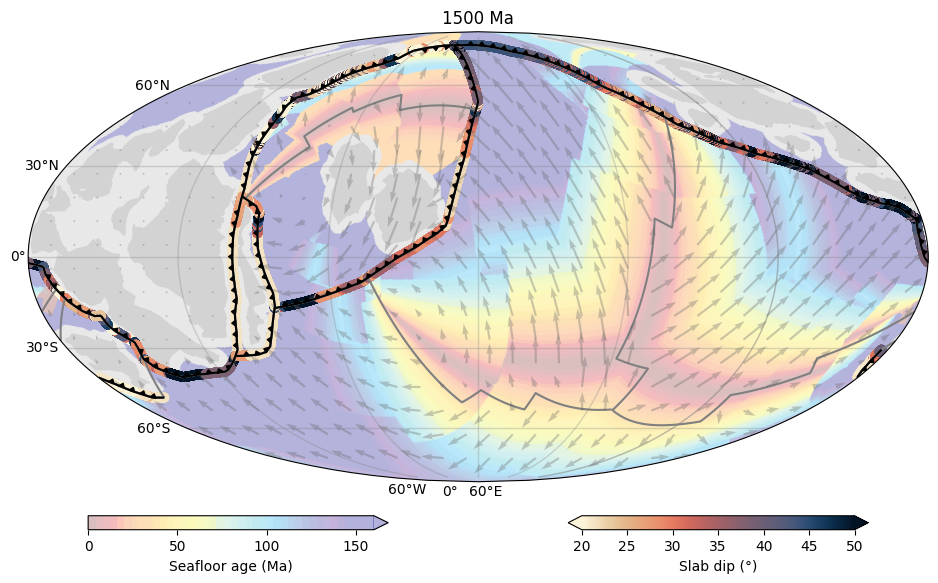

In [31]:
plot_slabdip(1500)

In [32]:
# Use LokyBackend to protect the netCDF routine
slabdip_img = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_slabdip) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.3min
/Users/laurenilano/opt/miniconda3/envs/gplately2025/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 43.8min
/Users/laurenilano/opt/miniconda3/envs/gplately2025/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed: 63.8min finished


In [45]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/slab_dip/slab_dip_{}.png".format(time)
    )

#clip = mpy.ImageSequenceClip(frame_list, fps=25)
#clip.write_videofile(
#    output_directory+"/slab_dip.mp4",
#    fps=24
#)

clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/slab_dip.mp4",
    fps=25,
    codec="libx264",
    bitrate="5000k",
    audio=False,
    logger=None,
    ffmpeg_params=[
        "-vf",
        "pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-pix_fmt",
        "yuv420p",
    ],
)


## Plots of subduction convergence rate and MOR spreading rate

In [36]:

conv_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('conv_cmap', ['white', 'mediumturquoise', 'teal', 'darkslategray', '#011C1A'])
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('conv_cmap', ['white', 'wheat', 'darkgoldenrod', '#7D4B20', '#1F1300'])


def plot_spread_conv(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr
    
    if time == 1800:
        original_time = time
        time = 1799
        ax.set_title("{} Ma".format(original_time))
        save_time = original_time
    else:
        ax.set_title("{} Ma".format(time))
        save_time = time

    extent_globe = [-180,180,-90,90]

    # ---------- PLOT THE AGE GRID
    age_grid, _ = defineGridFiles()
    agegrid = gplately.Raster(age_grid.format(time))

    cmap = custom_cmap
    cmap.set_bad('0.2',1.)

    im = ax.imshow(agegrid.data, extent=extent_globe, cmap=cmap, origin='lower', alpha=0.2,
*
               vmin=0, vmax=160, transform=ccrs.PlateCarree(), zorder=1
    )

    # ---------- PLOT COASTLINES, TOPOLOGIES ETC
    gplot.time = time
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.5, zorder=10, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='silver', edgecolor='none',)
    gplot.plot_trenches(ax, zorder=9)
    gplot.plot_subduction_teeth(ax, zorder=9)

    
    # ---------- COLLECT TRENCH DATA FROM H2O NOTEBOOK OUTPUTS
    subduction_filename = "../H2O/Outputs/subduction_timesteps/subduction_{:04d}Ma.h5"
    df_time = pd.read_hdf(subduction_filename.format(int(time)))
    
    curr_subd_lon = df_time["lon"].to_numpy()
    curr_subd_lat = df_time["lat"].to_numpy()
    curr_subd_convergence = np.clip(df_time['vel'].to_numpy(), 0, 1e99)*1e2 # Start in m, convert to cm

    # ---------- CALCULATE RIDGE DATA IN-SITU
    ridge_data = model.tessellate_mid_ocean_ridges(
        time,
        tessellation_threshold_radians=np.radians(0.01),
        anchor_plate_id=0)
    
    curr_mor_lon = ridge_data[:,0]
    curr_mor_lat = ridge_data[:,1]
    curr_mor_divergence = ridge_data[:,2] # already in cm/yr

    ax.set_global()
    
    # ---------- PLOT SCATTERPLOTS OF VELOCITIES USING CUSTOM COLORMAPS

    sc = ax.scatter(curr_subd_lon, curr_subd_lat, c=curr_subd_convergence, cmap=conv_cmap, vmin=0, vmax=14,
        transform=ccrs.PlateCarree(), rasterized=True, 
    )
    sc2 = ax.scatter(curr_mor_lon, curr_mor_lat, c=curr_mor_divergence, cmap=div_cmap, vmin=0, vmax=14,
        transform=ccrs.PlateCarree(), rasterized=True, 
    )
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)

     
    latlonticks(ax)

    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])

    cax1 = fig.add_axes([0.0, 0.21, 0.25, 0.02])
    cb1 = fig.colorbar(sc,  cax=cax1, ticks=np.arange(0,12.51,2.5), orientation='horizontal', label='Subduction convergence rate (cm/yr)', extend='max')

    cax2 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    cb2 = fig.colorbar(sc2,  cax=cax2, orientation='horizontal', label='Mid-ocean ridge spreading rate (cm/yr)', extend='max')

    cax3 = fig.add_axes([0.6, 0.21, 0.25, 0.02])
    cb2 = fig.colorbar(im,  cax=cax3, orientation='horizontal', label='Seafloor age (Myr)', extend='max')

    cb1.set_ticklabels(np.arange(0,12.51,2.5))
    #cb2.set_ticklabels(np.arange(0,12.51,2.5))
    
    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/subd_convergence", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/subd_convergence/subd_convergence_{}Ma.{}".format(save_time, out_format), dpi=300, bbox_inches='tight'
            )
    else:
        plt.show()
        
    plt.close()
    return

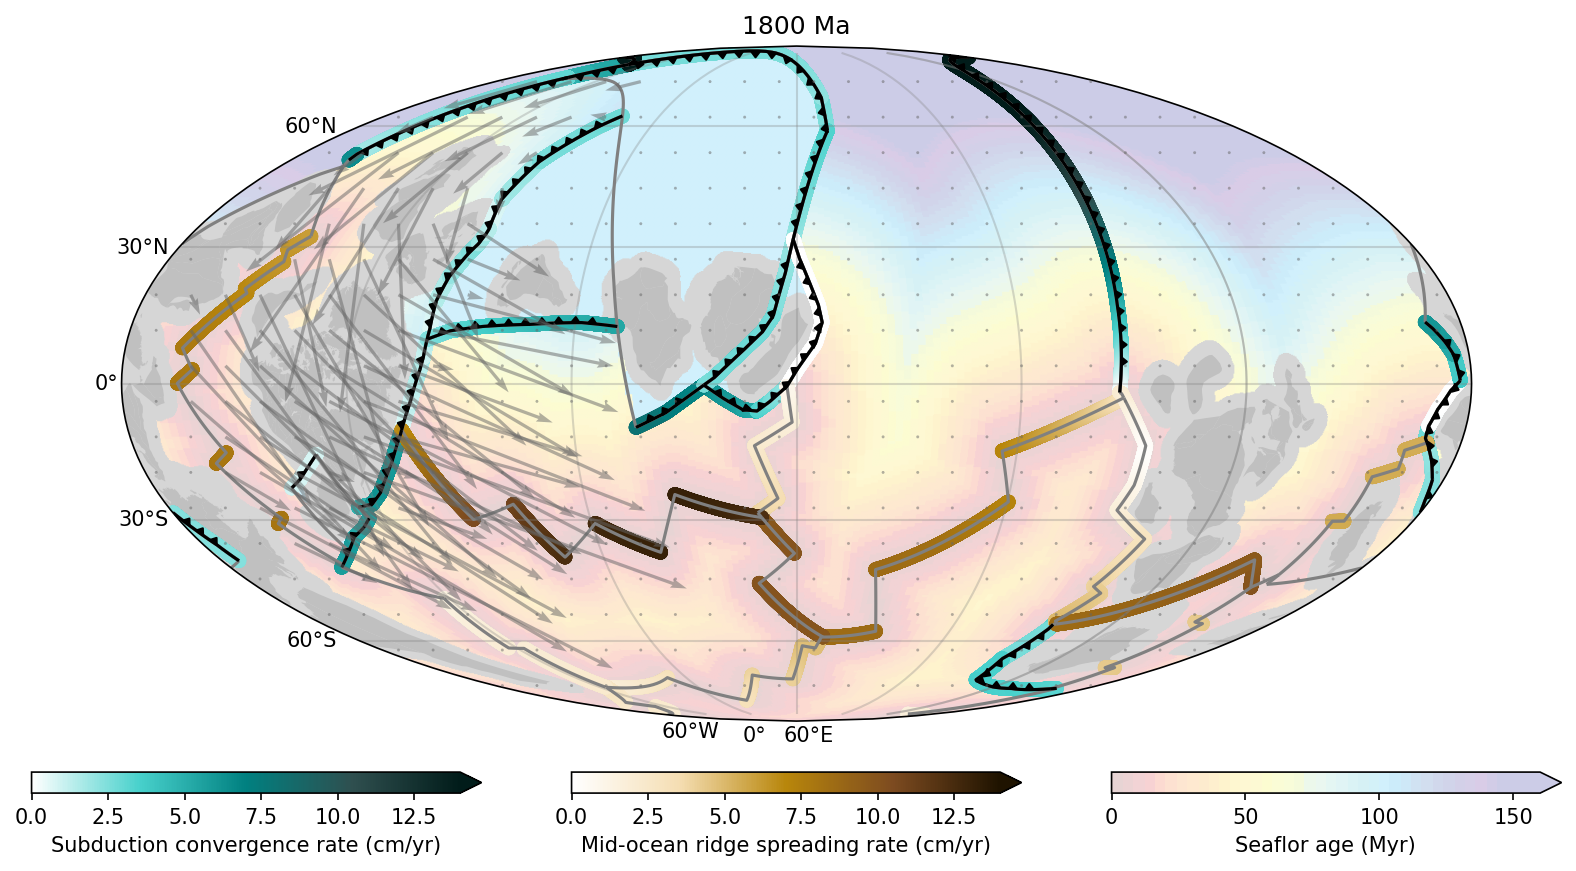

In [37]:
plot_spread_conv(1800)

In [38]:
# Use LokyBackend to protect the netCDF routine
spreading_convergence = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_spread_conv) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed: 82.2min finished


In [39]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/subd_convergence/subd_convergence_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/subd_convergence.mp4",
    fps=25,
    codec="libx264",
    bitrate="5000k",
    audio=False,
    logger=None,
    ffmpeg_params=[
        "-vf",
        "pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-pix_fmt",
        "yuv420p",
    ],
)


In [34]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/subd_convergence/subd_convergence_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/subd_convergence.mp4",
    codec='mpeg4', 
    ffmpeg_params=['-preset', 'veryslow', '-crf', '17'] 
)

Moviepy - Building video ./Outputs/Cao2024-Oct19/Videos//subd_convergence.mp4.
Moviepy - Writing video ./Outputs/Cao2024-Oct19/Videos//subd_convergence.mp4



Moviepy - Done !
Moviepy - video ready ./Outputs/Cao2024-Oct19/Videos//subd_convergence.mp4


## Plots of seafloor spreading rate

In [40]:
def plot_sfs(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr
    ax.set_facecolor('lightgrey')

    ax.set_title("{} Ma".format(time))

    extent_globe = [-180,180,-90,90]
    _, sr_grid = defineGridFiles()
    srgrid = gplately.Raster(sr_grid.format(time))

    im = ax.imshow(srgrid.data, extent=extent_globe, cmap='YlGnBu_r', origin='lower',

               vmin=0, vmax=160, transform=ccrs.PlateCarree(), zorder=1
    )
    gplot.time = time
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7, regrid_shape=20)
    gplot.plot_continents(ax, color='lightgrey')
    gplot.plot_coastlines(ax, facecolor='silver', edgecolor='none')
    gplot.plot_trenches(ax, color='w', linewidth=7, zorder=4)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, zorder=9, )
    gplot.plot_subduction_teeth(ax, zorder=9)

     
    latlonticks(ax)

    # fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max', shrink=0.4)
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    cb = fig.colorbar(im, cax=cax1, orientation='horizontal', label='Seafloor spreading rate (mm/yr)', shrink=0.8, pad=0.1, extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)

    if save_fig:
        os.makedirs(output_directory+"/seafloor_spreading_rate", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/seafloor_spreading_rate/seafloor_spreading_rate_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
        )
    else:
        plt.show()
    plt.close()
    return


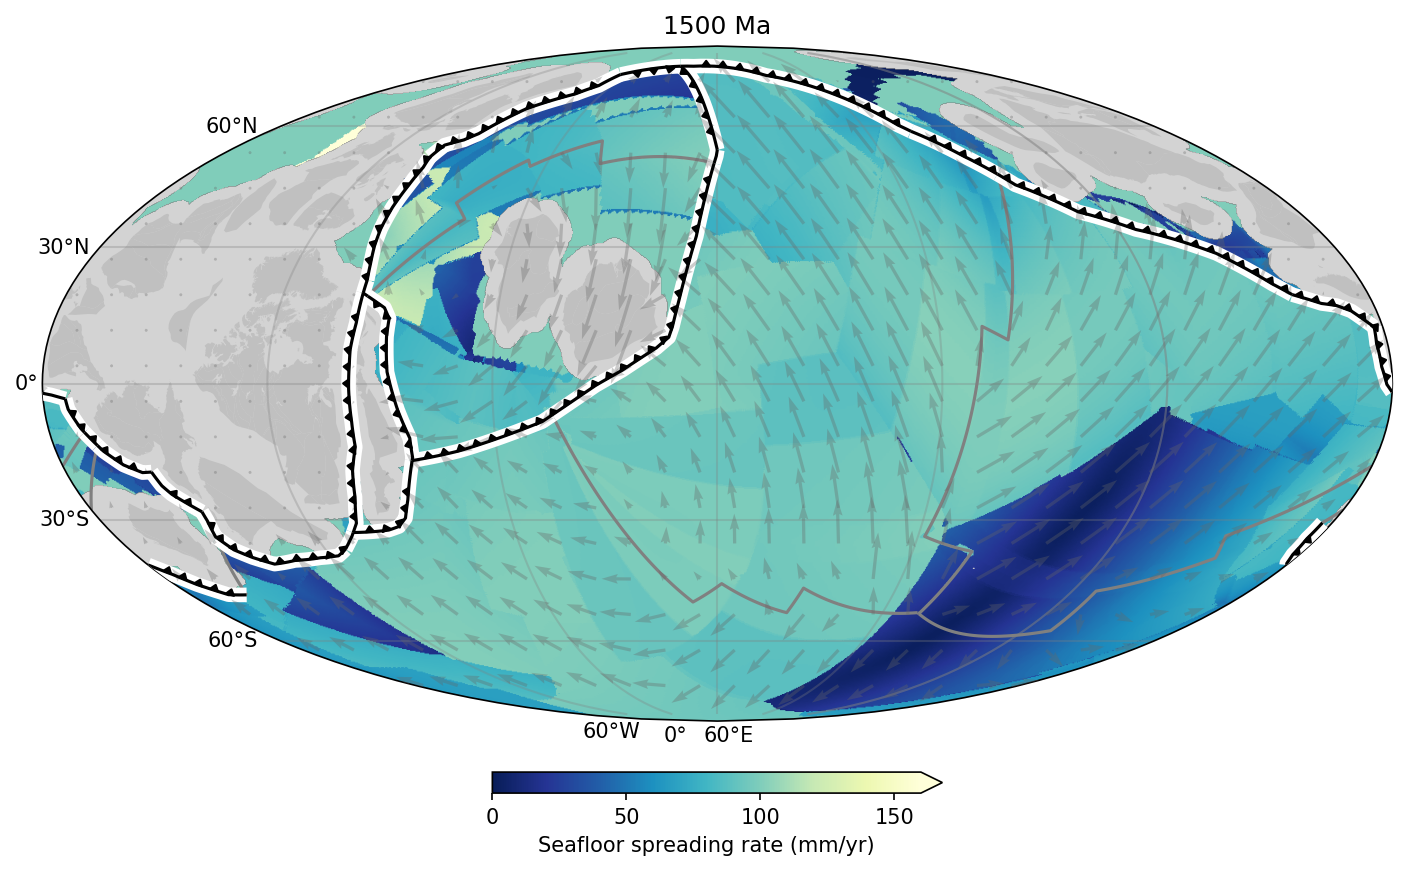

In [41]:
plot_sfs(time=1500)

In [42]:
# Use LokyBackend to protect the netCDF routine
sfs = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_sfs) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.1min
/Users/laurenilano/opt/miniconda3/envs/gplately2025/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  7.5min



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 20.0min



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 38.2min
/Users/laurenilano/opt/miniconda3/envs/gplately2025/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed: 55.3min finished


In [44]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/seafloor_spreading_rate/seafloor_spreading_rate_{}Ma.png".format(time)
    )


clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/seafloor_spreading_rate.mp4",
    fps=25,
    codec="libx264",
    bitrate="5000k",
    audio=False,
    logger=None,
    ffmpeg_params=[
        "-vf",
        "pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-pix_fmt",
        "yuv420p",
    ],
)

## Plots of organic sedimentary carbon

In [37]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plot_organic_sed(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    ax.set_facecolor('lightgrey')

    grd = gplately.Raster(

        "../Grids/Reservoirs/Organic_Sediments/mean/carbon_organic_sediments_grid_{:04d}.nc".format(time)
    ).data

    im = ax.imshow(
        grd*1e6, origin='lower', cmap=cm.batlow, vmin=0, vmax=5,
        transform=ccrs.PlateCarree(), interpolation='nearest'
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_continents(ax, color='lightgrey')
    gplot.plot_coastlines(ax, facecolor='silver',  edgecolor='silver',)
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, color='k', zorder=8)

     
    latlonticks(ax)


    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Carbon area density (T/m^$2$)', extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.1, hspace=0.1)

    if save_fig:
        os.makedirs(output_directory+"/organic_sediments", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/organic_sediments/organic_sediments_carbon_mean_area_density_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
    plt.close()
    return

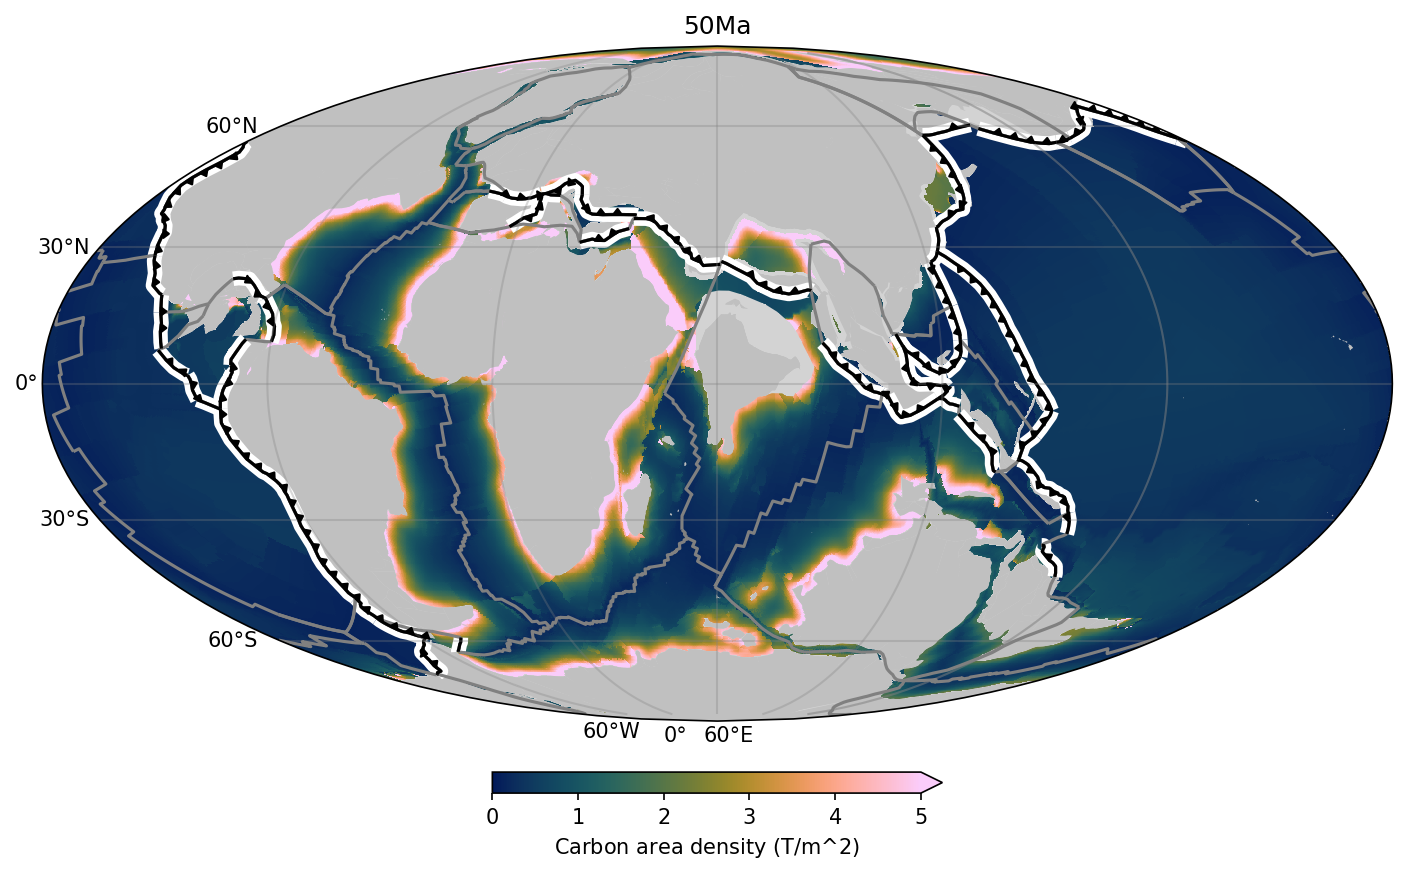

In [38]:
plot_organic_sed(time=50)

In [39]:
# Use LokyBackend to protect the netCDF routine
organic_seds = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_organic_sed) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  6.6min
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 15.8min finished


In [40]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/organic_sediments/organic_sediments_carbon_mean_area_density_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/organic_sediments_carbon_mean_area_density.mp4",
    fps=24
)

Moviepy - Building video ../Outputs/Muller22_Sep17/Videos//organic_sediments_carbon_mean_area_density.mp4.
Moviepy - Writing video ../Outputs/Muller22_Sep17/Videos//organic_sediments_carbon_mean_area_density.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Sep17/Videos//organic_sediments_carbon_mean_area_density.mp4


## Plots of total sediment thickness

In [7]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def plot_total_sed(time, save_fig=False):

    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr

    ax.set_facecolor('lightgrey')

    grd = gplately.Raster(
        grid_directory+"TotalSediment/sed_thick_0.1d_{:.1f}.nc".format(time)
    ).data

    lognorm_cmap = matplotlib.cm.viridis
    lognorm_cmap.set_bad((1,1,1), alpha=0)

    # time by 1e6 to go from Mt to t
    im = ax.imshow(
        grd, origin='lower', cmap=lognorm_cmap,
        norm=mcolors.LogNorm(vmin=1e1, vmax=1e3),
        transform=ccrs.PlateCarree(), interpolation='nearest'
    )

    ax.set_title("{}Ma".format(time))

    gplot.time = time
    gplot.plot_continents(ax, color='lightgrey')
    gplot.plot_coastlines(ax, facecolor='silver',  edgecolor='silver',)
    gplot.plot_trenches(ax, color='w', linewidth=7)
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, label = "Trenches with polarity teeth")
    gplot.plot_subduction_teeth(ax, color='k', zorder=8)

     
    latlonticks(ax)


    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Thickness (m)', extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.1, hspace=0.1)

    if save_fig:
        os.makedirs(output_directory+"/total_sediment", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/total_sediment/total_sediment_thickness_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
    plt.close()
    return

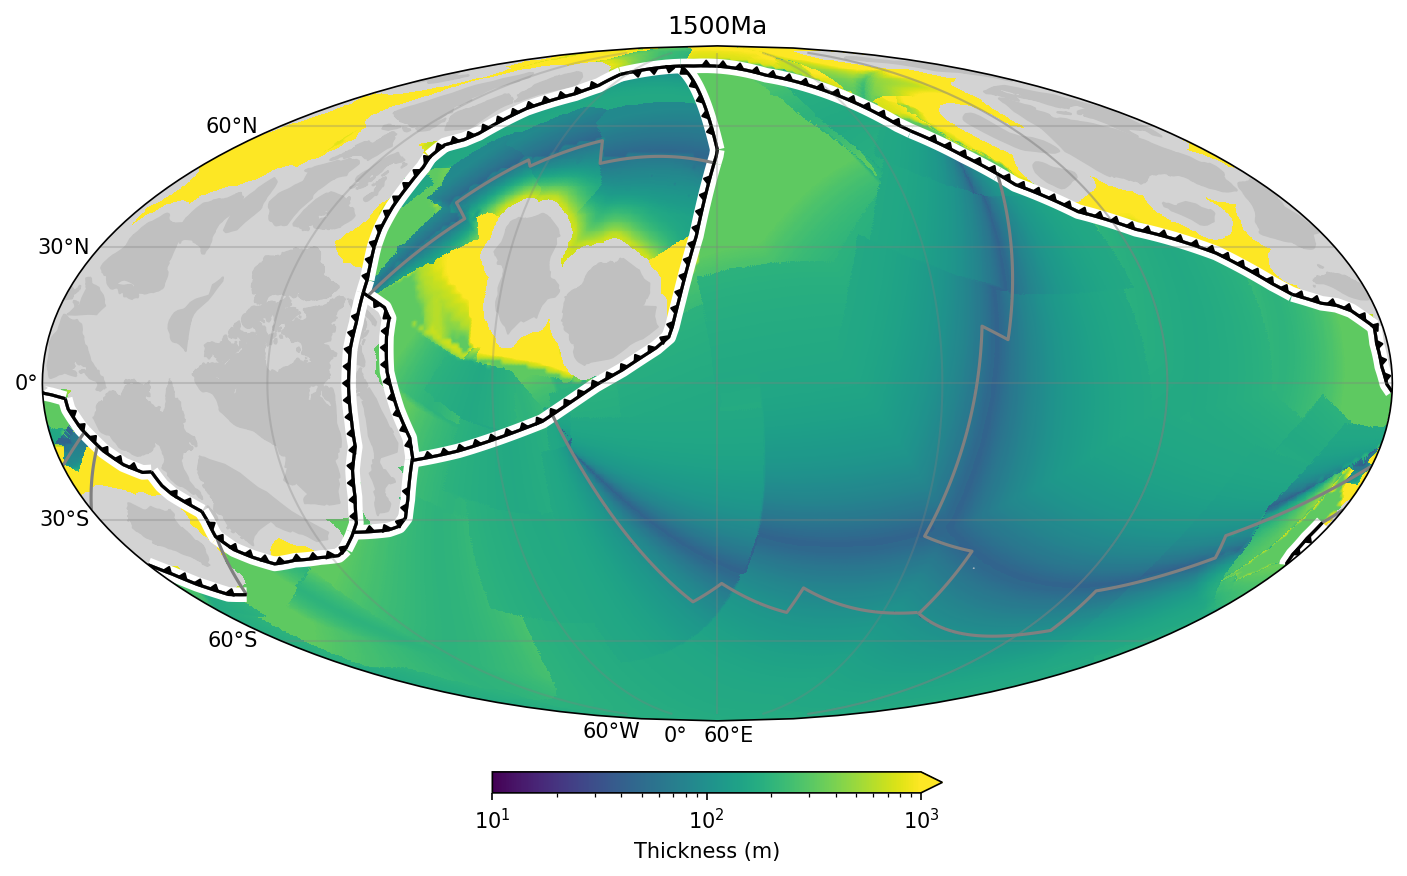

In [8]:
plot_total_sed(time=1500)

In [9]:
# Use LokyBackend to protect the netCDF routine
total_sed = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_total_sed) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



##################################################################################################

            You are using a DEV version (1.3.0.post153+git.f4b97d7d) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true, such as

            `os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"`(in Python)
            or
            `export DISABLE_GPLATELY_DEV_WARNING=true`(in Shell)
            
            If you prefer not seeing this warning always, you may set the environment variable 


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   53.9s
/Users/laurenilano/opt/miniconda3/envs/gplately2025/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 16.2min finished


In [10]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/total_sediment/total_sediment_thickness_{}Ma.png".format(time)
    )
    
clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/total_sediment_thickness.mp4",
    fps=25,
    codec="libx264",
    bitrate="8000k",
    audio=False,
    logger=None,
    ffmpeg_params=[
        "-vf",
        "pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-pix_fmt",
        "yuv420p",
    ],
)


In [41]:
frame_list = []
for time in reconstruction_times:
    frame_list.append(
        output_directory+"/total_sediment/total_sediment_thickness_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/total_sediment_thicknes.mp4",
    codec='mpeg4',
    bitrate='20000'
)

Moviepy - Building video ./Outputs/Cao2024-Oct19/Videos//total_sediment_thicknes.mp4.
Moviepy - Writing video ./Outputs/Cao2024-Oct19/Videos//total_sediment_thicknes.mp4



Moviepy - Done !
Moviepy - video ready ./Outputs/Cao2024-Oct19/Videos//total_sediment_thicknes.mp4


### Sediment accretion and erosion

In [45]:
def plot_sed_accreted(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    time_window = 10 #Myr
    
    if time == 1000:
        original_time = time
        time = 999
        ax.set_title("{} Ma".format(original_time))
        save_time = original_time
    else:
        ax.set_title("{} Ma".format(time))
        save_time = time

    extent_globe = [-180,180,-90,90]

    # ---------- PLOT COASTLINES, TOPOLOGIES ETC
    gplot.time = time
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.5, zorder=10, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='0.9', edgecolor='none')

    
    # ---------- COLLECT TRENCH DATA FROM H2O NOTEBOOK OUTPUTS
    subduction_filename = "../H2O/Outputs/subduction_timesteps/subduction_{:04d}Ma.h5"
    df_time = pd.read_hdf(subduction_filename.format(int(time)))
    
    curr_subd_lon = df_time["lon"].to_numpy()
    curr_subd_lat = df_time["lat"].to_numpy()
    curr_subd_convergence = np.clip(df_time['vel'].to_numpy(), 0, 1e99) # Start in m

    # Calculate sediment accretion at the current timestep
    accretion = (-0.4/0.068)*curr_subd_convergence + 0.4
    accretion_clipped = np.clip((-0.4/0.068)*curr_subd_convergence + 0.4, 0.0, 1e99)
    
    # Erosion
    erosion = 1 - accretion
    erosion_clipped = 1 - accretion_clipped
    
    accretion_pm40 = np.clip(accretion*100, -40., 40.),
    
    sc = ax.scatter(curr_subd_lon, curr_subd_lat, c=accretion_pm40, cmap='BrBG', vmin=-40, vmax=40,
                 transform=ccrs.PlateCarree(), rasterized=True,)
    
    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, zorder=9, color='k')
    gplot.plot_subduction_teeth(ax, zorder=9)     
    latlonticks(ax)


    gs = gridspec.GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    fig.colorbar(sc,  cax=cax1, orientation='horizontal', label='% Sediment accreted', extend='both')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.1, hspace=0.1)

    
    if save_fig:
        os.makedirs(output_directory+"/accretion", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/accretion/sed_accretion_to_erosion_{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
    plt.close()
    return

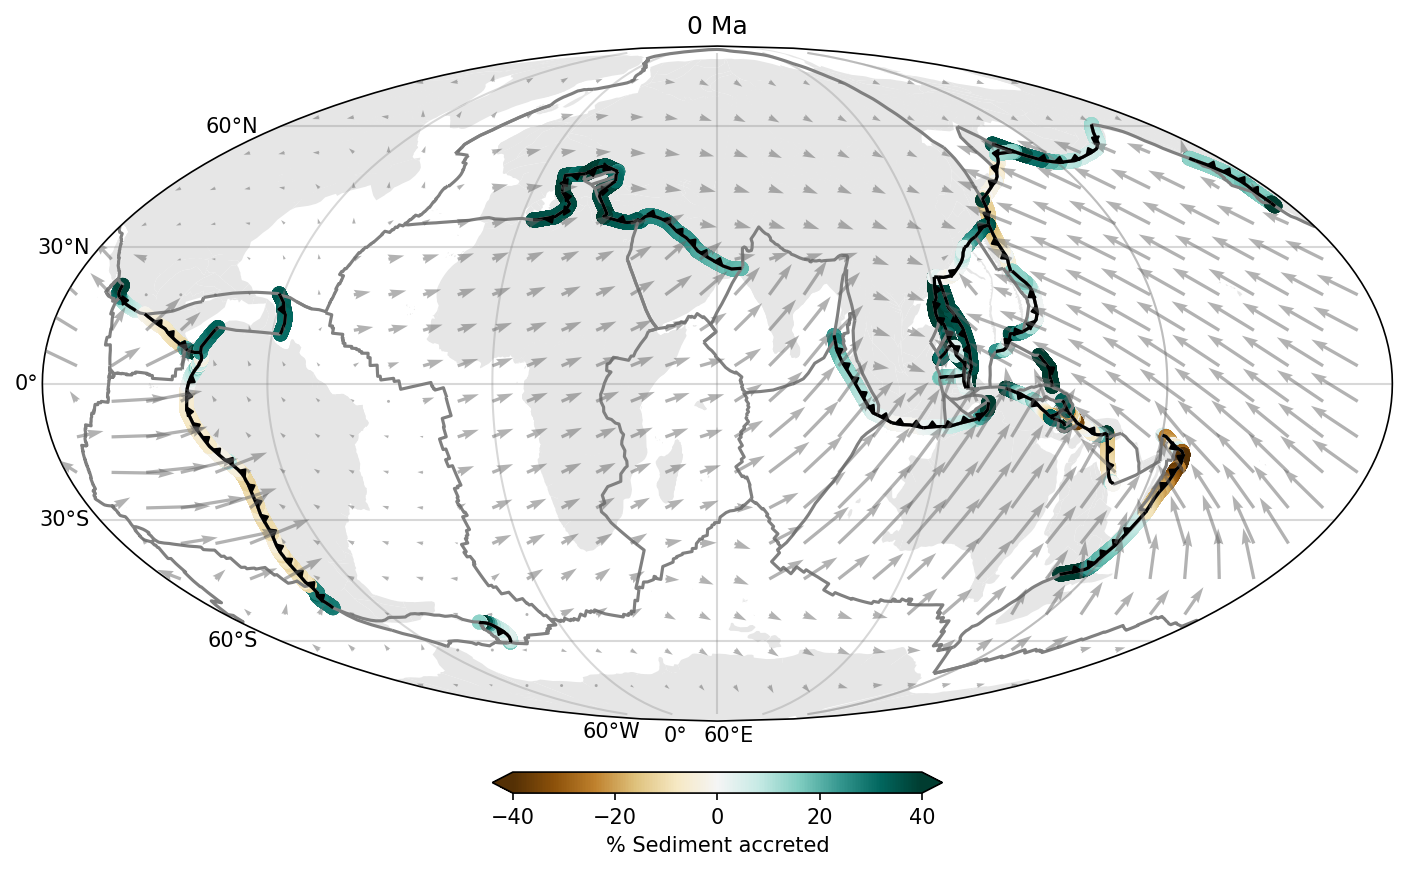

In [45]:
plot_sed_accreted(0)

In [46]:
# Use LokyBackend to protect the netCDF routine
carb_sed_times = np.arange(170,-1,-1)

accretion_erosion = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(plot_sed_accreted) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in carb_sed_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:  3.1min finished


In [47]:
frame_list = []
for time in carb_sed_times:
    frame_list.append(
        output_directory+"/accretion/sed_accretion_to_erosion_{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)

clip.write_videofile(
    output_directory+"/sed_accretion_to_erosion.mp4", fps=24, 
    codec='mpeg4', 
    ffmpeg_params=['-preset', 'veryslow', '-crf', '17'] )

Moviepy - Building video ../Outputs/Muller22_Sep17/Videos//sed_accretion_to_erosion.mp4.
Moviepy - Writing video ../Outputs/Muller22_Sep17/Videos//sed_accretion_to_erosion.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Sep17/Videos//sed_accretion_to_erosion.mp4


### Plots of subduction convergence at continental arcs

In [48]:
# For now, let's use the continent contours as the `gplot` continents
contoured_continents = '../Muller2022_InputGrids/ContinentalMasksNoArcs/continent_contour_features.gpmlz'

max_time = 1000
time = max_time
gplot = gplately.PlotTopologies(model, time=time, coastlines=coastlines, continents=contoured_continents)


In [49]:

# updated carbonate platforms file
platforms_filename = "./ActiveCarbonatePlatforms_Neoproterozoic-to-Present.gpml"

# ensure all features have an active time of 0
carb_platform_fc = pygplates.FeatureCollection(platforms_filename)

In [50]:
from scipy.spatial import cKDTree
from rasterio.features import rasterize
from rasterio.transform import from_bounds


def get_continent_polygon_coordinates(continent_polygons=None, grid=None, resX=0.2, resY=0.2):
    """
    Grids continents, and extracts coordinates
    Assumes 0.2 degree resolution by default
    """
    
    nx, ny = int(360/resX), int(180/resY)

    if grid:
        platforms_grid = gplately.Raster(grid,
            resample=(resY, resX),
        ).data
        xq, yq = np.meshgrid(np.arange(-180,180+resX,resX),
                             np.arange(-90, 90+resY, resY))
        
    elif continent_polygons:
        platforms_grid = rasterize(gplately.geometry.pygplates_to_shapely(continent_polygons),
                                   out_shape=(ny,nx),
                                   transform=from_bounds(-180, 90, 180, -90, nx, ny))

        xq, yq = np.meshgrid(np.linspace(-180,180,nx),
                             np.linspace(-90, 90, ny))

    mask_grid = platforms_grid > 0
    xcoords = xq[mask_grid]
    ycoords = yq[mask_grid]
    return xcoords, ycoords


# Get present-day subduction zone coordinates
time = 0
d_tols = [350]

def get_continental_arc_speeds(time):
    
    # reconstruct continents
    gplot.time = time
    
    agegrid_filename, spreadrate_filename = defineGridFiles()
    tessellation_threshold_radians = np.radians(0.01)

    # Get continets 
    clons, clats = get_continent_polygon_coordinates(grid=grid_directory+"/ContinentalMasksNoArcs/continent_mask_{}.0.nc".format(time))
    
    ###################### Subduction convergence data ########################
    # Initialise SlabDipper object, allocate it a spreading rate grid and an age grid
    dipper = SlabDipper()
    dipper._model = model
    dipper.set_age_grid_filename(agegrid_filename)
    dipper.set_spreading_rate_grid_filename(spreadrate_filename)

    subduction_df = dipper.tessellate_slab_dip(time, tessellation_threshold_radians)

    subduction_lon     = subduction_df.lon
    subduction_lat     = subduction_df.lat
    subduction_length  = subduction_df.length # m
    subd_len_sum = np.sum(subduction_length) 

    subduction_convergence = subduction_df.vel * 100 # m/yr to cm/yr
    subd_vel_mean, subd_vel_std = np.mean(subduction_convergence), np.std(subduction_convergence)

    # area subducted by trenches over 1 yr
    subd_surface_area = np.sum(subduction_convergence * subduction_length) # m^2/yr

    
    ################## K-D TREE 1: Find trenches intersecting continent polygons ############

    trench_xyz   = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat, degrees=True)
    continent_xyz = gplately.tools.lonlat2xyz(clons, clats, degrees=True)
    tree = cKDTree(np.c_[continent_xyz])
    distance_to_trench, index = tree.query(np.c_[trench_xyz])
    distance_to_trench *= 6371
    
    length_per_dtol = np.zeros((len(d_tols), 1))
    
    for i, d_tol in enumerate(d_tols):
        mask_dist = distance_to_trench <= d_tol

        in_continent_trench_lons = subduction_lon[mask_dist]
        in_continent_trench_lats = subduction_lat[mask_dist]
        in_continent_trench_vel = subduction_convergence[mask_dist]
        
    if time > 500:
        return in_continent_trench_lons, in_continent_trench_lats, in_continent_trench_vel, clons, clats, None, None
        
    else:
        ################## K-D TREE 2: Find continent arcs intersecting carbonate platforms ############
        cont_arc_xyz = gplately.tools.lonlat2xyz(in_continent_trench_lons, in_continent_trench_lats, degrees=True)

        # Reconstruct carbonate platforms at this time 
        reconstructed_platforms = model.reconstruct(platforms_filename, time)
        cp_lons, cp_lats = get_continent_polygon_coordinates(continent_polygons=reconstructed_platforms)
        carb_plat_xyz = gplately.tools.lonlat2xyz(cp_lons, cp_lats, degrees=True)

        carb_plat_tree = cKDTree(np.c_[carb_plat_xyz])
        distance_to_cont_arc, index = carb_plat_tree.query(np.c_[cont_arc_xyz])
        distance_to_cont_arc *= 6371

        for i, d_tol in enumerate(d_tols):
            mask_dist = distance_to_cont_arc <= d_tol

            carb_plat_intersecting_lons = in_continent_trench_lons[mask_dist]
            carb_plat_intersecting_lats = in_continent_trench_lats[mask_dist]
            carb_plat_intersecting_vel = in_continent_trench_vel[mask_dist]


        return carb_plat_intersecting_lons, carb_plat_intersecting_lats, carb_plat_intersecting_vel, clons, clats, cp_lons, cp_lats

In [51]:
def plot_trench_on_continental_arcs(time, save_fig=False):
    
    proj = ccrs.Mollweide(central_longitude=60)
    fig, ax = plt.subplots(1,1, subplot_kw={'projection': proj}, figsize=(12, 7), dpi=150)

    ax.set_title("{} Ma".format(time))

    extent_globe = [-180,180,-90,90]

    gplot.time = time

    
    
    if time > 500:
        lons, lats, speeds, clon, clat, _,_ = get_continental_arc_speeds(time)
    else:
        lons, lats, speeds, clon, clat, cplon, cplat = get_continental_arc_speeds(time)
        
    
    im = ax.scatter(clon, clat, transform=ccrs.PlateCarree(), color='gainsboro', s=5)
    gplot.plot_coastlines(ax, facecolor='0.7', edgecolor='none')
    
    if time < 501:
        cp = ax.scatter(cplon, cplat, transform=ccrs.PlateCarree(), color='#ABCDEF', alpha=0.1, s=0.5)
        
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7)
    
    im = ax.scatter(lons, lats, transform=ccrs.PlateCarree(), c=speeds, vmax=10, vmin=0, s=40, cmap='plasma')
    gplot.plot_trenches(ax, color='w', linewidth=4)

    gplot.plot_all_topological_sections(ax, color='grey', tessellate_degrees=1)
    gplot.plot_trenches(ax, zorder=9, )
    gplot.plot_subduction_teeth(ax, zorder=9)

    latlonticks(ax)

    # fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max', shrink=0.4)
    cax1 = fig.add_axes([0.3, 0.21, 0.25, 0.02])
    cb = fig.colorbar(im, cax=cax1, orientation='horizontal', label='Convergence rate (cm/yr)', shrink=0.8, pad=0.1, extend='max')

    fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.80,
                    wspace=0.001, hspace=0.3)
    
    ax.set_global()
    
    if save_fig:
        os.makedirs(output_directory+"/continental_arcs", exist_ok=True)
        for out_format in ["png"]:
            fig.savefig(output_directory+"/continental_arcs/continental_arc_convergence{}Ma.{}".format(time, out_format), dpi=300, bbox_inches='tight'
                       )
    else:
        plt.show()
    plt.close()
    return

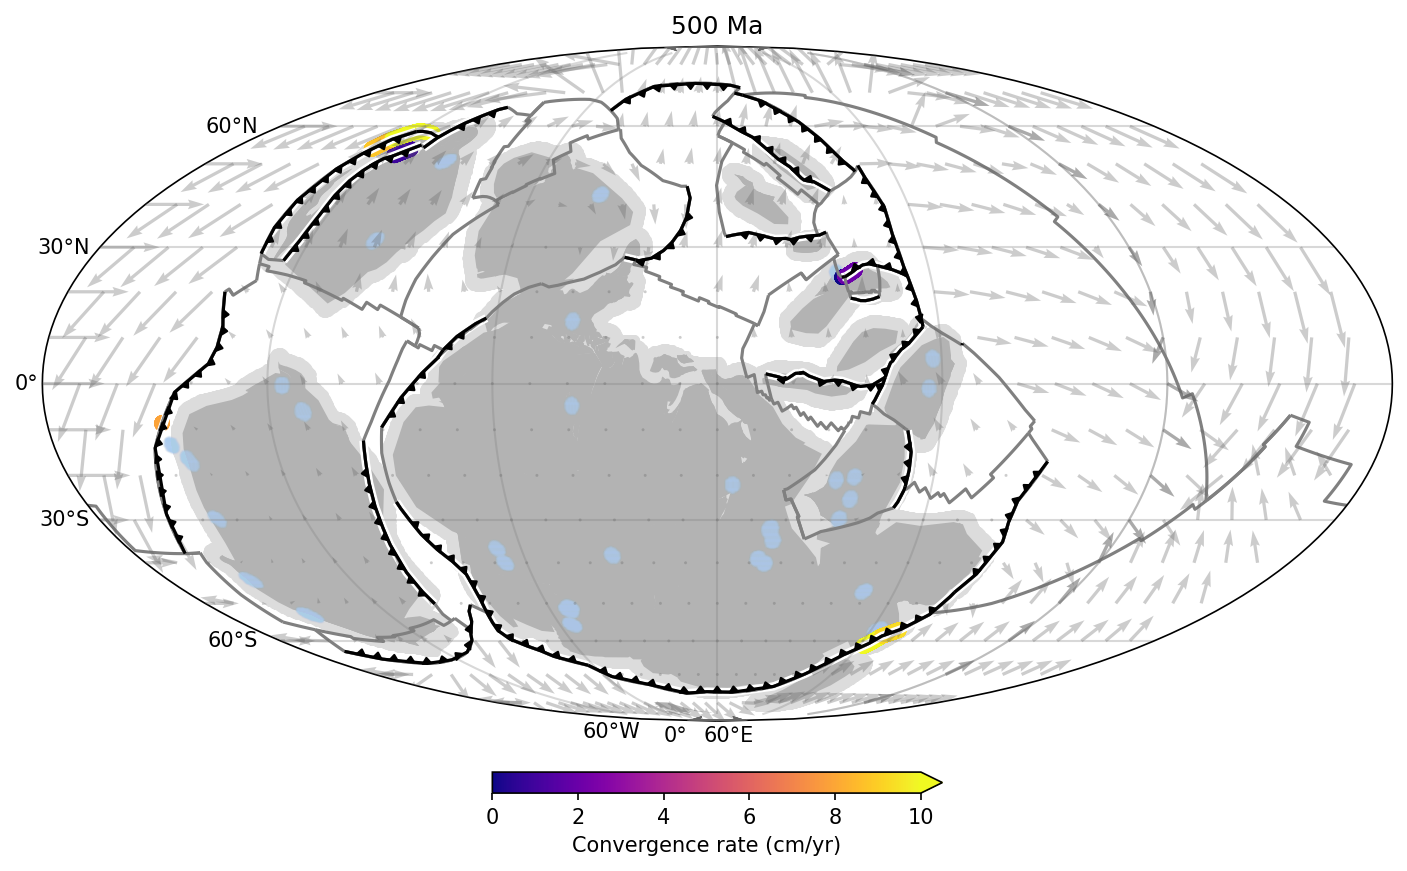

In [52]:
plot_trench_on_continental_arcs(500)

In [53]:
%env PYTHONWARNINGS=ignore::RuntimeWarning
"""       
# Use LokyBackend to protect the netCDF routine
cont_arc = Parallel(n_jobs=-1, backend='threading', verbose=1) \
(delayed(plot_trench_on_continental_arcs) \
 (reconstruction_time, 
  save_fig=True, 
 ) for reconstruction_time in np.arange(1000,346,-1))
"""
for time in np.arange(500, -1, -1):
    plot_trench_on_continental_arcs(time, save_fig=True)

env: PYTHONWARNINGS=ignore::RuntimeWarning


In [54]:
frame_list = []
for time in np.arange(500,-1,-1):
    frame_list.append(
        output_directory+"/continental_arcs/continental_arc_convergence{}Ma.png".format(time)
    )

clip = mpy.ImageSequenceClip(frame_list, fps=25)
clip.write_videofile(
    output_directory+"/continental_arc_convergence.mp4",
    fps=24
)

Moviepy - Building video ../Outputs/Muller22_Sep17/Videos//continental_arc_convergence.mp4.
Moviepy - Writing video ../Outputs/Muller22_Sep17/Videos//continental_arc_convergence.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Sep17/Videos//continental_arc_convergence.mp4
